# Options Data EDA & Project Description

Implement methods outlined in paper [Adaptive Gradient Descent Methods for Computing Implied Volatility](https://arxiv.org/pdf/2108.07035v1)

For testing this we are using a [dataset](https://www.dolthub.com/repositories/post-no-preference/options?source=post_page-----99046f1dc128---------------------------------------) to test our volatiltiy strategy


The paper talks about traditional root finding methods like the Newton-Raphson method, and their shortcomings such as a high non-convergence rates in practice of ~32%

The paper also discusses methods for applying gradient descent to the root finding problem. Essentially instead of searching for $g(\sigma) = 0$, this method minimizes the squared difference between the model price and the observed market price:

$$ min_{\sigma} h(\sigma) = (s\Phi(d_1) - ke^{-rt}\Phi(d2) - c)^2$$

Since $h(\sigma)$ is non-negative and is locally parabolic like around its minimum, finding the value of $\sigma$ that minimizes $h(\sigma)$ is equivalent to finding $g(\sigma) = 0$

To begin lets load a sample dataset from above

In [1]:
import pandas as pd


opt_chain = pd.read_json("option_chain.json", convert_dates=True)
volatility_history = pd.read_json("volatility_history.json", convert_dates=True)

In [2]:
opt_chain.head()

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
0,2019-02-09,A,2019-02-15,65.0,Call,10.50,11.25,0.2705,1.0000,0.0000,-0.0046,0.0000,0.0124
1,2019-02-09,A,2019-02-15,65.0,Put,0.00,0.03,0.3133,-0.0002,0.0002,-0.0002,0.0001,0.0000
2,2019-02-09,A,2019-02-15,67.5,Call,8.15,8.50,0.2705,0.9991,0.0010,-0.0053,0.0003,0.0129
3,2019-02-09,A,2019-02-15,67.5,Put,0.00,0.03,0.3133,-0.0034,0.0031,-0.0024,0.0011,0.0000
4,2019-02-09,A,2019-02-15,70.0,Call,5.70,6.00,0.2705,0.9845,0.0137,-0.0127,0.0041,0.0132


In [3]:
opt_chain.shape

(1000, 13)

In [4]:
opt_chain.act_symbol.unique()

array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN',
       'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES',
       'AFL', 'AGN'], dtype=object)

In [5]:
opt_chain.groupby("act_symbol").date.unique()

act_symbol
A       [2019-02-09 00:00:00]
AAL     [2019-02-09 00:00:00]
AAP     [2019-02-09 00:00:00]
AAPL    [2019-02-09 00:00:00]
ABBV    [2019-02-09 00:00:00]
ABC     [2019-02-09 00:00:00]
ABMD    [2019-02-09 00:00:00]
ABT     [2019-02-09 00:00:00]
ACN     [2019-02-09 00:00:00]
ADBE    [2019-02-09 00:00:00]
ADI     [2019-02-09 00:00:00]
ADM     [2019-02-09 00:00:00]
ADP     [2019-02-09 00:00:00]
ADS     [2019-02-09 00:00:00]
ADSK    [2019-02-09 00:00:00]
AEE     [2019-02-09 00:00:00]
AEP     [2019-02-09 00:00:00]
AES     [2019-02-09 00:00:00]
AFL     [2019-02-09 00:00:00]
AGN     [2019-02-09 00:00:00]
Name: date, dtype: object

In [6]:
# get historical price for each symbol
from yfinance import download
from datetime import datetime, timedelta

symbols = list(opt_chain.act_symbol.unique())
target_date = datetime.strptime("2019-02-09", "%Y-%m-%d")

# Download a week of data to ensure we get trading days
data = download(
    symbols,
    start=target_date - timedelta(days=7),
    end=target_date + timedelta(days=3),
    group_by="ticker",
    progress=False,
)

/tmp/ipykernel_346607/2746179956.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = download(

4 Failed downloads:
['ABMD', 'ADS', 'AGN', 'ABC']: YFTzMissingError('possibly delisted; no timezone found')


In [7]:
closing_prices = data.stack(level=0).loc[('2019-02-08',), 'Close']  
closing_prices.head()

/tmp/ipykernel_346607/3704105920.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  closing_prices = data.stack(level=0).loc[('2019-02-08',), 'Close']


Ticker
A        72.181221
AAL      35.523727
AAP     143.824188
AAPL     40.720955
ABBV     59.518341
Name: Close, dtype: float64

In [8]:
# add close to opt_chain
opt_chain = opt_chain.merge(
    closing_prices.rename("underlying_price"),
    left_on="act_symbol",
    right_index=True,
)

In [9]:
volatility_history.head()

,date,act_symbol,hv_current,hv_week_ago,hv_month_ago,hv_year_high,hv_year_high_date,hv_year_low,hv_year_low_date,iv_current,iv_week_ago,iv_month_ago,iv_year_high,iv_year_high_date,iv_year_low,iv_year_low_date
0,2019-02-09,A,0.2418,0.3048,0.3433,0.4045,2019-01-03,0.1174,2018-10-03,0.2673,0.2487,0.2898,0.3610,2018-12-24,0.1647,2018-08-31
1,2019-02-09,AAL,0.4745,0.5612,0.6403,0.6428,2019-01-07,0.2363,2018-03-28,0.3453,0.3481,0.5038,0.6498,2018-12-24,0.2761,2018-03-16
2,2019-02-09,AAP,0.3112,0.3174,0.2733,0.4491,2018-04-02,0.1543,2018-07-17,0.4431,0.3986,0.3255,0.6006,2019-02-09,0.2223,2018-08-24
3,2019-02-09,AAPL,0.4373,0.5048,0.5061,0.5162,2019-01-04,0.1134,2018-06-22,0.2280,0.2285,0.3371,0.4552,2018-12-24,0.1592,2018-05-25
4,2019-02-09,ABBV,0.3718,0.4075,0.3512,0.5371,2018-05-03,0.1774,2018-09-12,0.2393,0.2420,0.3483,0.4489,2018-12-24,0.1923,2018-08-27


In [10]:
volatility_history.shape

(1000, 16)

## Testing the Adaptive Gradient Descent IV Calculator

Now let's test the adaptive gradient descent implied volatility calculator from `p2_implied_vol_calculator.py` using the options data we've loaded above.

In [11]:
# Import the calculator module
%load_ext autoreload
%autoreload 2
from p2_implied_vol_calculator import (
    compute_everything_adaptive_gd,
    print_detailed_summary,
)

# Run the adaptive gradient descent IV calculator
# Using a smaller max_iterations for testing purposes

# Prepare the data - the opt_chain already has underlying_price from yfinance
results_df = compute_everything_adaptive_gd(
    df=opt_chain.copy(),
    risk_free_rate=0.05,
    optimizer_type="adam",  # Can also try "adabelief"
    initial_sigma=0.4,  # Paper's recommended initial guess
)


DATA PREPARATION
Original rows: 856
Removed: 91 (10.6%)
Final dataset: 765 options
  Symbols: 16
  Date range: 2019-02-09 00:00:00 to 2019-02-09 00:00:00
  Expirations: 5

Converting to tensors...
✓ Converted 765 options to tensors
ADAPTIVE GRADIENT DESCENT IV SOLVER
Options to solve: 765
Optimizer: ADAM
Initial σ₀: 0.4
Learning rate η: 0.001
Max iterations: 2000
Convergence threshold: 0.0001
Iteration    0 | Converged:     0/765 (  0.0%) | Loss: 1.41e+03
Iteration  100 | Converged:   142/765 ( 18.6%) | Loss: 1.40e+03
Iteration  200 | Converged:   215/765 ( 28.1%) | Loss: 1.40e+03
Iteration  300 | Converged:   288/765 ( 37.6%) | Loss: 1.39e+03
Iteration  400 | Converged:   345/765 ( 45.1%) | Loss: 1.39e+03
Iteration  500 | Converged:   416/765 ( 54.4%) | Loss: 1.39e+03
Iteration  600 | Converged:   487/765 ( 63.7%) | Loss: 1.39e+03
Iteration  700 | Converged:   551/765 ( 72.0%) | Loss: 1.39e+03
Iteration  800 | Converged:   612/765 ( 80.0%) | Loss: 1.39e+03
Iteration  900 | Converged:

In [12]:
# Print detailed performance summary
print_detailed_summary(results_df)


DETAILED PERFORMANCE METRICS

-------------------------Overall Performance--------------------------
Total options: 765
Converged: 707 (92.42%)
Non-Convergence Rate (NC): 7.5817%

-------------------Implied Volatility Distribution--------------------
Mean IV: 0.246060
Median IV: 0.197015
Std Dev: 0.179074
Min IV: 0.003288
Max IV: 1.085651

---------------------------Pricing Accuracy---------------------------
Mean Absolute Error (MAE): 17.857719
RMSE: 38.660778
Mean % Error: 3077.9871%

------------------------Convergence Statistics------------------------
Average iterations: 449.7
Median iterations: 410
Max iterations: 1980

------------------------Performance by Symbol-------------------------
A     :    26 options | Avg IV: 0.2103 | MAE: 2.478176
AAL   :    57 options | Avg IV: 0.3007 | MAE: 0.582322
AAP   :    32 options | Avg IV: 0.1935 | MAE: 12.500256
AAPL  :    66 options | Avg IV: 0.4000 | MAE: 121.276802
ABBV  :    59 options | Avg IV: 0.2262 | MAE: 15.964414
ABT   :    49 o

In [13]:
# Display sample results
print("\nSample Results:")
print("=" * 70)
display_cols = [
    'act_symbol', 'strike', 'call_put', 'market_price', 
    'implied_volatility', 'bs_price', 'pricing_error', 
    'iv_converged', 'iv_iterations'
]
results_df[display_cols].head(10)


Sample Results:


,act_symbol,strike,call_put,market_price,implied_volatility,bs_price,pricing_error,iv_converged,iv_iterations
0,A,65.0,Call,10.875,2.564404,5.789030,5.085970,False,0
2,A,67.5,Call,8.325,2.211025,5.723476,2.601523,False,0
4,A,70.0,Call,5.850,1.743450,5.266935,0.583065,False,0
5,A,70.0,Put,0.040,0.160602,0.040018,0.000018,True,1190
6,A,72.5,Call,3.475,0.904562,3.474983,0.000017,True,1550
7,A,72.5,Put,0.135,0.007953,0.259216,0.124216,True,870
8,A,75.0,Call,1.410,0.079850,2.757179,1.347179,True,630
9,A,75.0,Put,0.560,0.079209,2.757179,2.197179,True,610
10,A,77.5,Call,0.220,0.141024,5.255119,5.035120,True,450
11,A,77.5,Put,1.850,0.141134,5.255119,3.405119,True,450


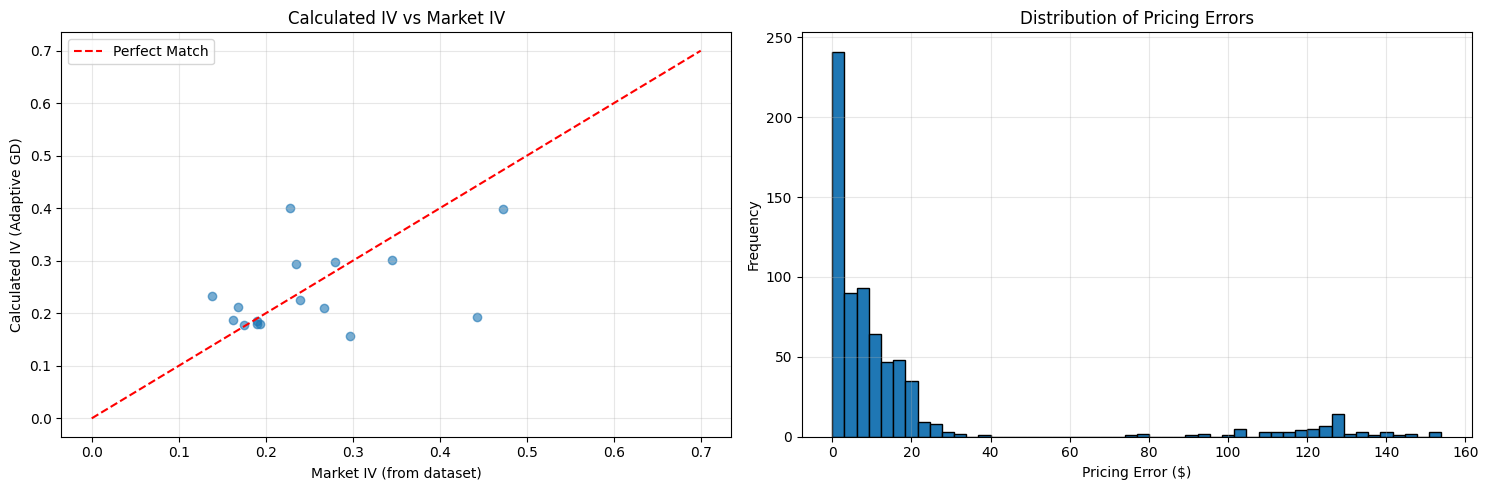


Correlation between Calculated IV and Market IV: 0.42440519267980326


In [14]:
# Compare calculated IV with market IV from volatility_history
import matplotlib.pyplot as plt

# Merge with volatility history to compare
comparison = results_df[results_df['iv_converged']].merge(
    volatility_history[['act_symbol', 'iv_current', 'hv_current']],
    on='act_symbol',
    how='left'
)

# Group by symbol to get average calculated IV
symbol_iv = comparison.groupby('act_symbol').agg({
    'implied_volatility': 'mean',
    'iv_current': 'first',
    'hv_current': 'first'
}).reset_index()

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Calculated IV vs Market IV
ax1.scatter(symbol_iv['iv_current'], symbol_iv['implied_volatility'], alpha=0.6)
ax1.plot([0, 0.7], [0, 0.7], 'r--', label='Perfect Match')
ax1.set_xlabel('Market IV (from dataset)')
ax1.set_ylabel('Calculated IV (Adaptive GD)')
ax1.set_title('Calculated IV vs Market IV')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution of pricing errors
ax2.hist(results_df[results_df['iv_converged']]['pricing_error'], bins=50, edgecolor='black')
ax2.set_xlabel('Pricing Error ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Pricing Errors')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation between Calculated IV and Market IV:", 
      symbol_iv['implied_volatility'].corr(symbol_iv['iv_current']))